# FASTTEXT

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

from tensorflow.keras.callbacks import EarlyStopping

keras.utils.set_random_seed(42)

## LOAD DATA

In [2]:
# Load the Drive helper and mount

# This will prompt for authorization.
drive.mount('/content/drive')

project_folder = '/content/drive/My Drive/AML-Project-Frigerio-Napoli-Tremolada'

df_train = pd.read_csv(f'{project_folder}/train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
test_data = pd.read_csv(f'{project_folder}/test.csv')
test_labels = pd.read_csv(f'{project_folder}/test_labels.csv')
df_test = pd.merge(test_data, test_labels, on='id')

In [4]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult","identity_hate"]

In [5]:
df_test = df_test[(df_test[labels] >= 0).all(1)]
df_test.reset_index(inplace=True)
df_test = df_test.drop(columns=['index'])

In [6]:
from sklearn.model_selection import train_test_split

X = df_train["comment_text"]
y = df_train[labels].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test["comment_text"]
y_test = df_test[labels].values

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def preprocess(text):
  text = text.lower() # convert text to lowercase
  text = re.sub(r'\d+', '', text) # remove numbers
  text = str(text).replace("\n", " ") # remove newline characters
  text = re.sub(r'[^\w\s]', '', text) #
  text = text.strip() # remove whitespaces

  # remove stop words
  stop_words = set(stopwords.words('english'))
  word_tokens = word_tokenize(text)
  filtered_tokens = [token.lower() for token in word_tokens if token.lower() not in stop_words]

  # Lemmatize the tokens
  lemmatizer=WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

  # Join the tokens back into a string
  preprocessed_text = " ".join(lemmatized_tokens)

  return preprocessed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
X_train_pp = X_train.apply(preprocess)
X_val_pp = X_val.apply(preprocess)
X_test_pp = X_test.apply(preprocess)

In [9]:
MAX_LEN = 200
VOCABULARY_SIZE = 200000

auto = tf.data.AUTOTUNE
text_vectorizer = layers.TextVectorization(
    max_tokens=VOCABULARY_SIZE, ngrams=1, output_mode="int",
    output_sequence_length=MAX_LEN
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(X_train_pp)

In [10]:
X_train_vc = text_vectorizer(X_train_pp)
X_val_vc = text_vectorizer(X_val_pp)
X_test_vc = text_vectorizer(X_test_pp)

In [11]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train_vc, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val_vc, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test_vc, y_test))

In [12]:
BATCH_SIZE = 64

ds_train = ds_train.cache().batch(BATCH_SIZE).prefetch(16)
ds_val = ds_val.cache().batch(BATCH_SIZE).prefetch(16)
ds_test = ds_test.cache().batch(BATCH_SIZE).prefetch(16)

## EMBEDDING

In [13]:
EMBEDDING_DIM = 300

vocabulary = text_vectorizer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

NUM_TOKEN = len(vocabulary) + 2

with open('/content/drive/My Drive/AML-toxic/emft.npy', 'rb') as f:
    emft = np.load(f)

In [14]:
embedding_layer_transformer = layers.Embedding(
    NUM_TOKEN,
    EMBEDDING_DIM,
    trainable=False,
)
embedding_layer_transformer.build((1,))
embedding_layer_transformer.set_weights([emft.copy()])

In [15]:
embedding_layer_rnn = layers.Embedding(
    NUM_TOKEN,
    EMBEDDING_DIM,
    trainable=False,
)
embedding_layer_rnn.build((1,))
embedding_layer_rnn.set_weights([emft.copy()])

In [16]:
embedding_layer_cnn = layers.Embedding(
    NUM_TOKEN,
    EMBEDDING_DIM,
    trainable=False,
)
embedding_layer_cnn.build((1,))
embedding_layer_cnn.set_weights([emft.copy()])

## MODELS

In [17]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [18]:
# Model parameters
NUM_HEADS = 3
FF_DIM = 300

def make_transformer():
    inputs = keras.Input(shape=(MAX_LEN,))
    embedding = embedding_layer_transformer(inputs)
    transformer_block = TransformerBlock(EMBEDDING_DIM, NUM_HEADS, FF_DIM)
    x = transformer_block(embedding)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(len(labels), activation = 'sigmoid')(x)

    return keras.Model(inputs, outputs)

In [19]:
def make_rnn():
    inputs = keras.Input(shape=(MAX_LEN,))
    embedding = embedding_layer_rnn(inputs)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences = False))(embedding)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(len(labels), activation = 'sigmoid')(x)

    return keras.Model(inputs, outputs)

In [20]:
FILTERS = 250 #number of filters
KERNEL_SIZE = 5 # a window size of 3 tokens

def make_cnn():
    inputs = keras.Input(shape=(MAX_LEN,))
    embedding = embedding_layer_cnn(inputs)
    x = keras.layers.Conv1D(FILTERS, KERNEL_SIZE, activation = 'relu')(embedding)
    x = keras.layers.GlobalMaxPooling1D()(x)
    x = keras.layers.Conv1D(FILTERS*2, KERNEL_SIZE, activation = 'relu')(embedding)
    x = keras.layers.GlobalMaxPooling1D()(x)
    x = keras.layers.Dense(500, activation = 'relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = layers.Dense(len(labels), activation = 'sigmoid')(x)

    return keras.Model(inputs, outputs)

In [21]:
auc_metric = keras.metrics.AUC(multi_label=True)

In [22]:
model_transformer = make_transformer()
model_transformer.summary()
model_transformer.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=["binary_accuracy", auc_metric]
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          55737900  
                                                                 
 transformer_block (Transfo  (None, 200, 300)          1264800   
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               30100 

In [23]:
model_rnn = make_rnn()
model_rnn.summary()
model_rnn.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=["binary_accuracy", auc_metric]
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 300)          55737900  
                                                                 
 bidirectional (Bidirection  (None, 256)               439296    
 al)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                           

In [24]:
model_cnn = make_cnn()
model_cnn.summary()
model_cnn.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics=["binary_accuracy", auc_metric]
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 300)          55737900  
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 500)          750500    
                                                                 
 global_max_pooling1d_1 (Gl  (None, 500)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_6 (Dense)             (None, 500)               250500    
                                                                 
 dropout_6 (Dropout)         (None, 500)               0         
                                                           

## TRAIN AND EVALUATE

### UTILITY FUNCTIONS

In [25]:
import matplotlib.pyplot as plt

def plot_result(history, item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

In [26]:
def train_model(m, es):
  history = m.fit(ds_train, validation_data=ds_val, epochs=20, callbacks=[es])
  plot_result(history, "loss")
  plot_result(history, "binary_accuracy")
  plot_result(history, "auc")

In [27]:
from sklearn.metrics import roc_auc_score, classification_report

def print_roc(y_true, y_preds):
  print("ROC AUC Score per Label\t",roc_auc_score(y_true,y_preds,average=None))
  print("Micro ROC AUC Score\t",roc_auc_score(y_true,y_preds,average="micro"))
  print("Macro ROC AUC Score\t",roc_auc_score(y_true,y_preds,average="macro"))
  print("Weighted ROC AUC Score\t",roc_auc_score(y_true,y_preds,average="weighted"))
  print(classification_report(y_true, (y_preds > 0.5), target_names=labels))

In [28]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

def print_cms(y_true, y_preds):
  cms = multilabel_confusion_matrix(y_true, (y_preds > 0.5))

  for cm, l in zip(cms, labels):
    true_neg, false_pos, false_neg, true_pos = cm.ravel()
    acc = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
    recall = true_pos / (true_pos + false_neg)
    precision = true_pos / (true_pos + false_pos)
    f1_score = 2 * ((precision * recall) / (precision + recall))
    print(f'{l} - Acc: {acc:.4f} - Recall: {recall:.4f} - Precision: {precision:.4f} - F1 score: {f1_score:.4f}')
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

In [29]:
def model_metrics(m):
  y_preds = m.predict(ds_test.map(lambda text, label: text))
  y_true = np.concatenate([y for x, y in ds_test], axis=0)
  print_roc(y_true, y_preds)
  print_cms(y_true, y_preds)
  return y_preds

In [30]:
from operator import itemgetter

vocab_arr = np.asarray(vocabulary)
def seq_to_text(seq):
  return " ".join(vocab_arr[seq])

def model_comments(pos, model_preds):
  toxic_indices = [i for i, x in enumerate(np.array(y_test)) if x[pos]==1]
  toxic_comments = np.array(X_test_pp)[np.array(toxic_indices)]
  toxic_labels = np.array(y_test)[np.array(toxic_indices)]
  y_preds_converted = (model_preds > 0.5).astype(int)[np.array(toxic_indices)]
  assert len(toxic_comments) == len(toxic_labels) == len(y_preds_converted)
  count = 0
  for t, l, pred in zip(toxic_comments, toxic_labels, y_preds_converted):
    if not np.any(pred):
      count += 1
    # print(f'-----\n{t}:\n\t{l}\t{pred}')
  print(f'Total Predictions: {len(model_preds)}')
  print(f'Total Toxic Comments with label `{labels[pos]}`: {len(toxic_comments)}')
  percentage =  (count *100)/ len(y_preds_converted)
  print(f'Percentage of all-zero predictions: {percentage}')

### TRANSFORMER

Epoch 1/20
1995/1995 [==============================] - 139s 65ms/step - loss: 0.0661 - binary_accuracy: 0.9775 - auc: 0.9308 - val_loss: 0.0556 - val_binary_accuracy: 0.9802 - val_auc: 0.9581
Epoch 2/20
1995/1995 [==============================] - 131s 66ms/step - loss: 0.0527 - binary_accuracy: 0.9806 - auc: 0.9552 - val_loss: 0.0546 - val_binary_accuracy: 0.9809 - val_auc: 0.9636
Epoch 3/20
1995/1995 [==============================] - 131s 66ms/step - loss: 0.0503 - binary_accuracy: 0.9812 - auc: 0.9600 - val_loss: 0.0493 - val_binary_accuracy: 0.9818 - val_auc: 0.9716


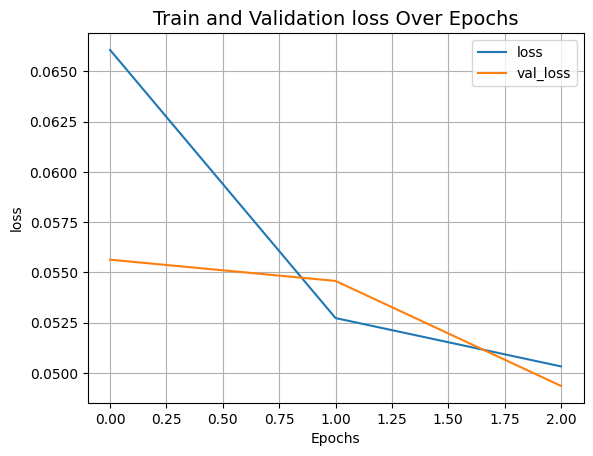

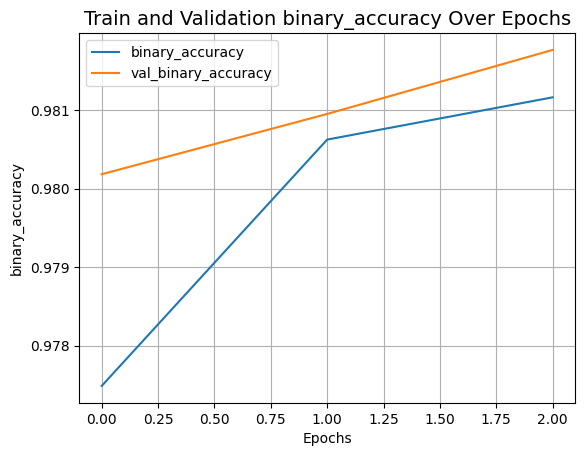

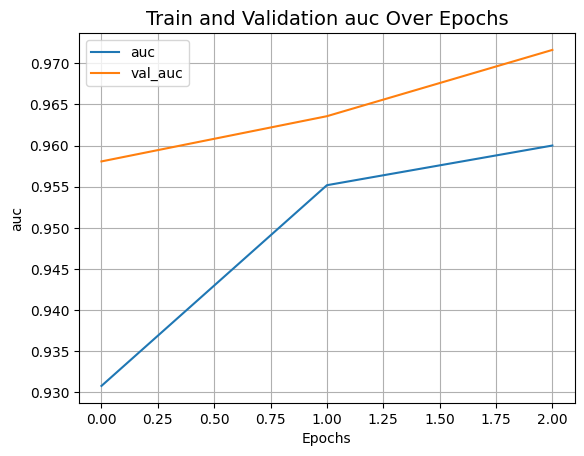

In [31]:
train_model(model_transformer, EarlyStopping(monitor="val_loss", min_delta = 0.01, patience=2, restore_best_weights=True))

In [32]:
model_transformer.evaluate(ds_test)

1000/1000 [==============================] - 23s 23ms/step - loss: 0.0811 - binary_accuracy: 0.9691 - auc: 0.9543


[0.0810660794377327, 0.9690590500831604, 0.9543333053588867]

1000/1000 [==============================] - 22s 22ms/step
ROC AUC Score per Label	 [0.9579312  0.98163356 0.97229755 0.93200936 0.96157468 0.94378292]
Micro ROC AUC Score	 0.9713402270929836
Macro ROC AUC Score	 0.9582048771347389
Weighted ROC AUC Score	 0.9619778327412609


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        toxic       0.55      0.82      0.66      6090
 severe_toxic       0.36      0.10      0.15       367
      obscene       0.71      0.59      0.64      3691
       threat       0.00      0.00      0.00       211
       insult       0.56      0.54      0.55      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.58      0.62      0.60     14498
    macro avg       0.37      0.34      0.33     14498
 weighted avg       0.56      0.62      0.58     14498
  samples avg       0.07      0.06      0.06     14498

toxic - Acc: 0.9196 - Recall: 0.8194 - Precision: 0.5522 - F1 score: 0.6598


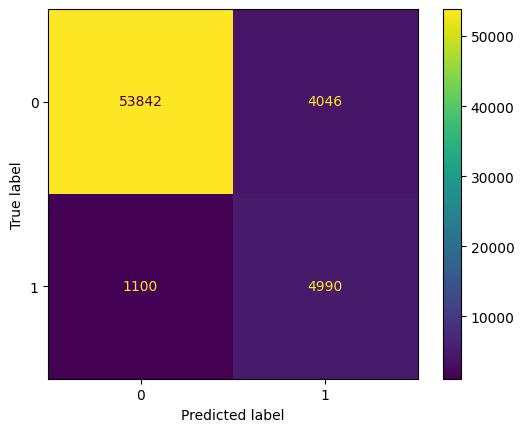

severe_toxic - Acc: 0.9939 - Recall: 0.0954 - Precision: 0.3646 - F1 score: 0.1512


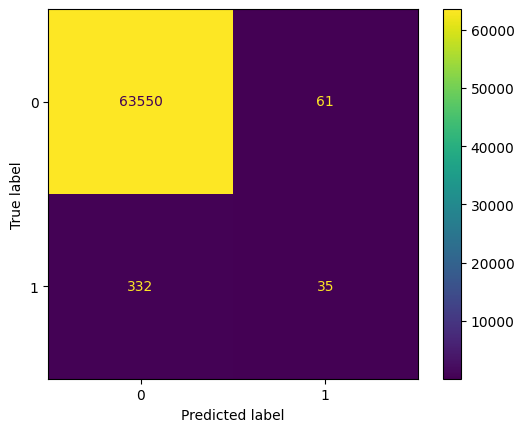

obscene - Acc: 0.9624 - Recall: 0.5882 - Precision: 0.7106 - F1 score: 0.6436


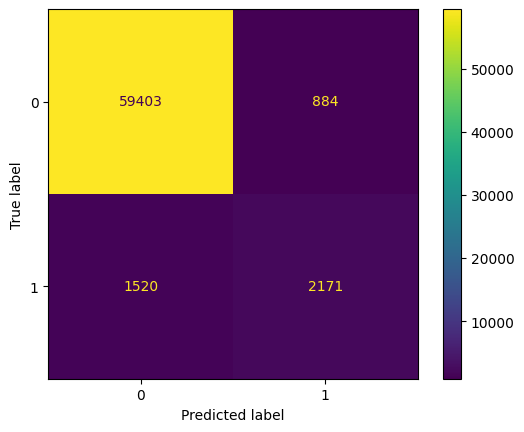

threat - Acc: 0.9967 - Recall: 0.0000 - Precision: nan - F1 score: nan


<ipython-input-28-e33fee1fdeaa>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_pos / (true_pos + false_pos)


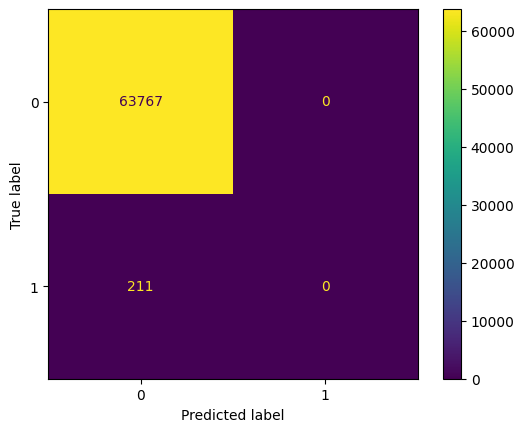

insult - Acc: 0.9529 - Recall: 0.5410 - Precision: 0.5632 - F1 score: 0.5519


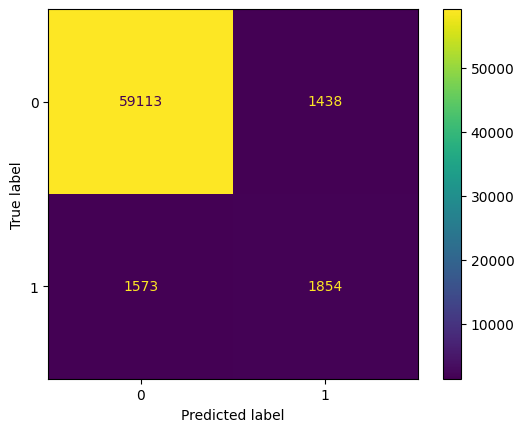

identity_hate - Acc: 0.9889 - Recall: 0.0000 - Precision: nan - F1 score: nan


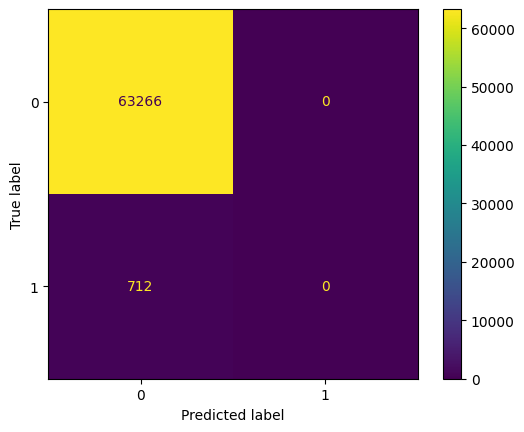

In [33]:
mt_preds = model_metrics(model_transformer)

In [34]:
model_comments(3, mt_preds)

Total Predictions: 63978
Total Toxic Comments with label `threat`: 211
Percentage of all-zero predictions: 16.587677725118482


In [35]:
model_comments(5, mt_preds)

Total Predictions: 63978
Total Toxic Comments with label `identity_hate`: 712
Percentage of all-zero predictions: 10.955056179775282


In [36]:
embedding_layer_transformer.trainable = True
model_transformer.compile(
  loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["binary_accuracy", auc_metric]
)

Epoch 1/20
1995/1995 [==============================] - 247s 122ms/step - loss: 0.0502 - binary_accuracy: 0.9815 - auc: 0.9572 - val_loss: 0.0488 - val_binary_accuracy: 0.9819 - val_auc: 0.9700
Epoch 2/20
1995/1995 [==============================] - 167s 84ms/step - loss: 0.0438 - binary_accuracy: 0.9828 - auc: 0.9715 - val_loss: 0.0488 - val_binary_accuracy: 0.9818 - val_auc: 0.9739
Epoch 3/20
1995/1995 [==============================] - 167s 84ms/step - loss: 0.0388 - binary_accuracy: 0.9842 - auc: 0.9787 - val_loss: 0.0492 - val_binary_accuracy: 0.9815 - val_auc: 0.9708


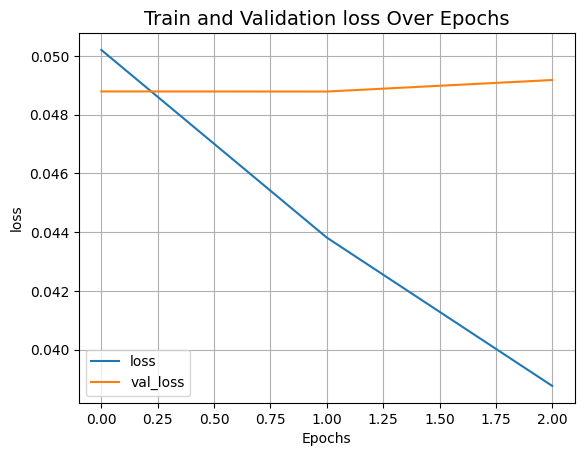

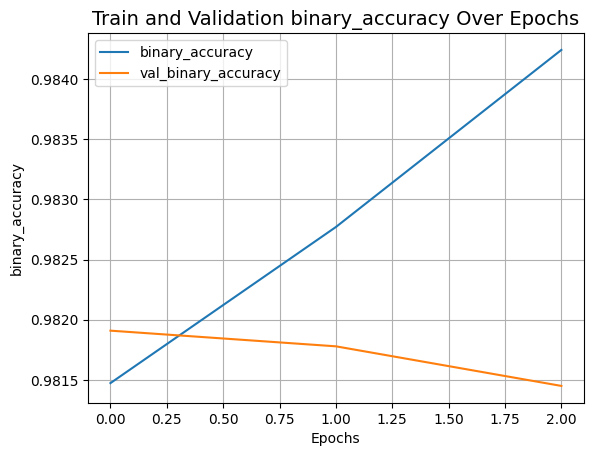

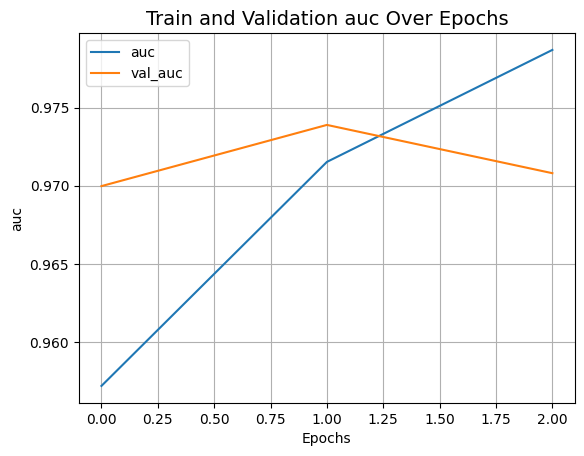

In [37]:
train_model(model_transformer, EarlyStopping(monitor="val_loss", min_delta = 0.005, patience=2, restore_best_weights=True))

In [38]:
model_transformer.evaluate(ds_test)

1000/1000 [==============================] - 24s 24ms/step - loss: 0.0876 - binary_accuracy: 0.9645 - auc: 0.9663


[0.08762761205434799, 0.9644825458526611, 0.9662873148918152]

1000/1000 [==============================] - 22s 22ms/step
ROC AUC Score per Label	 [0.96195759 0.98599027 0.97571985 0.95577698 0.96610536 0.96761158]
Micro ROC AUC Score	 0.976994142711399
Macro ROC AUC Score	 0.9688602717596041
Weighted ROC AUC Score	 0.9672377965030392
               precision    recall  f1-score   support

        toxic       0.51      0.89      0.65      6090
 severe_toxic       0.30      0.61      0.40       367
      obscene       0.58      0.82      0.68      3691
       threat       0.00      0.00      0.00       211
       insult       0.52      0.70      0.60      3427
identity_hate       0.27      0.00      0.01       712

    micro avg       0.52      0.76      0.62     14498
    macro avg       0.36      0.50      0.39     14498
 weighted avg       0.50      0.76      0.60     14498
  samples avg       0.07      0.07      0.07     14498

toxic - Acc: 0.9078 - Recall: 0.8911 - Precision: 0.5089 - F1 score: 0.6478


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


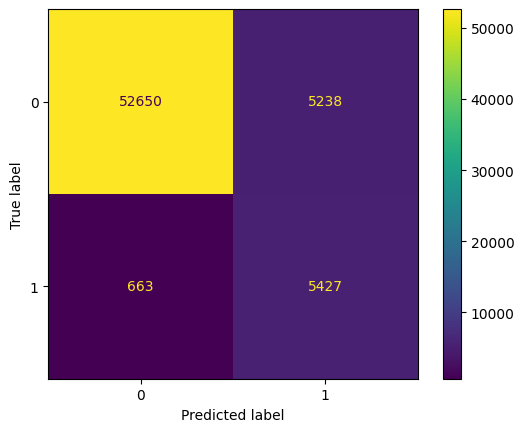

severe_toxic - Acc: 0.9896 - Recall: 0.6104 - Precision: 0.2999 - F1 score: 0.4022


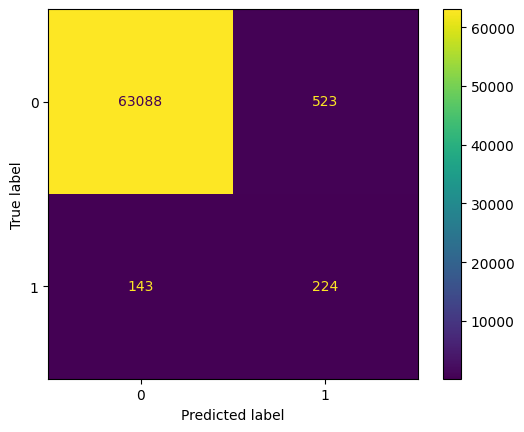

obscene - Acc: 0.9549 - Recall: 0.8217 - Precision: 0.5765 - F1 score: 0.6776


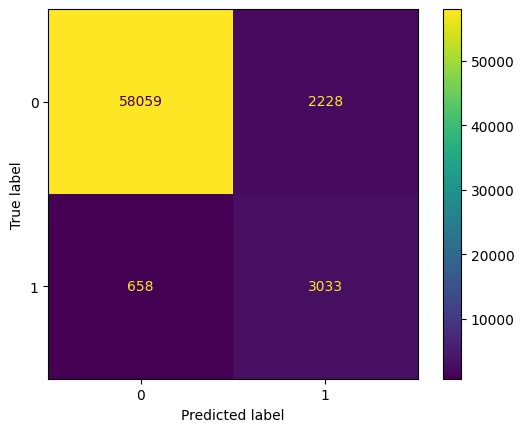

threat - Acc: 0.9967 - Recall: 0.0000 - Precision: nan - F1 score: nan


<ipython-input-28-e33fee1fdeaa>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_pos / (true_pos + false_pos)


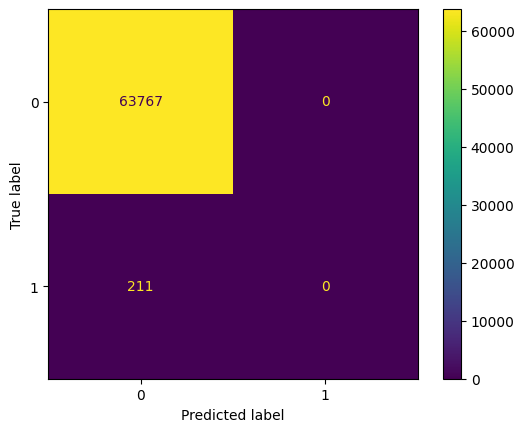

insult - Acc: 0.9492 - Recall: 0.6997 - Precision: 0.5188 - F1 score: 0.5959


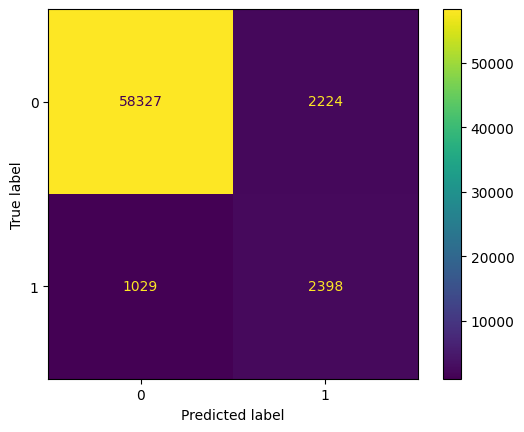

identity_hate - Acc: 0.9888 - Recall: 0.0042 - Precision: 0.2727 - F1 score: 0.0083


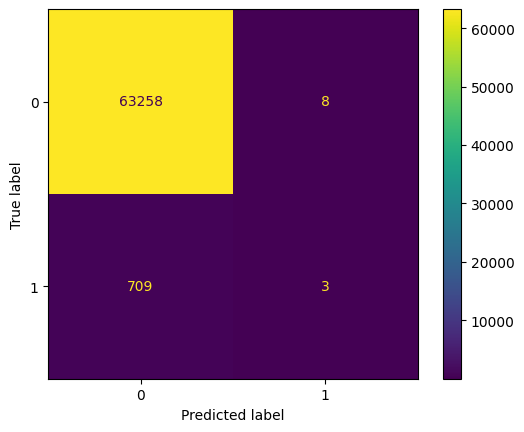

In [39]:
mtt_preds = model_metrics(model_transformer)

In [40]:
model_comments(3, mtt_preds)

Total Predictions: 63978
Total Toxic Comments with label `threat`: 211
Percentage of all-zero predictions: 7.5829383886255926


In [41]:
model_comments(5, mtt_preds)

Total Predictions: 63978
Total Toxic Comments with label `identity_hate`: 712
Percentage of all-zero predictions: 7.443820224719101


### RNN

Epoch 1/20
1995/1995 [==============================] - 58s 27ms/step - loss: 0.0655 - binary_accuracy: 0.9774 - auc: 0.9453 - val_loss: 0.0516 - val_binary_accuracy: 0.9807 - val_auc: 0.9618
Epoch 2/20
1995/1995 [==============================] - 53s 26ms/step - loss: 0.0493 - binary_accuracy: 0.9814 - auc: 0.9668 - val_loss: 0.0480 - val_binary_accuracy: 0.9818 - val_auc: 0.9687
Epoch 3/20
1995/1995 [==============================] - 54s 27ms/step - loss: 0.0456 - binary_accuracy: 0.9824 - auc: 0.9719 - val_loss: 0.0463 - val_binary_accuracy: 0.9822 - val_auc: 0.9702


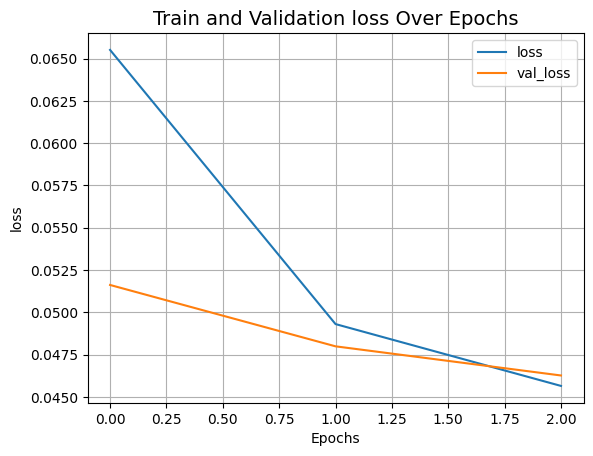

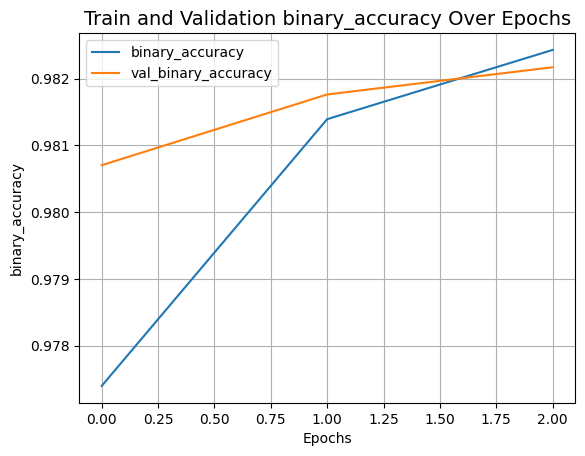

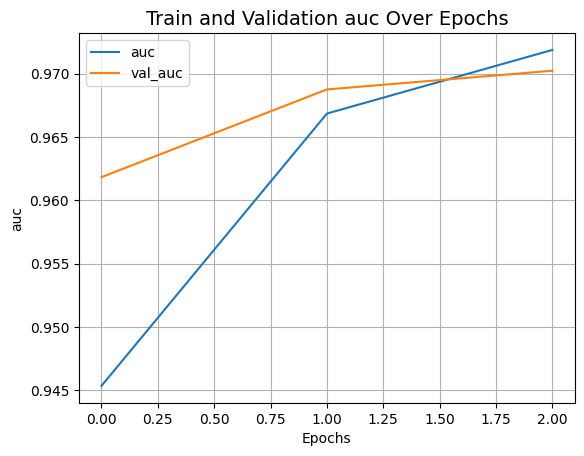

In [42]:
train_model(model_rnn, EarlyStopping(monitor="val_loss", min_delta = 0.01, patience=2, restore_best_weights=True))

In [43]:
model_rnn.evaluate(ds_test)

1000/1000 [==============================] - 11s 11ms/step - loss: 0.0722 - binary_accuracy: 0.9708 - auc: 0.9625


[0.07217691838741302, 0.9707582592964172, 0.9624853134155273]

1000/1000 [==============================] - 9s 9ms/step
ROC AUC Score per Label	 [0.9580906  0.9845468  0.97219158 0.95838255 0.96300573 0.96370287]
Micro ROC AUC Score	 0.9745838111200762
Macro ROC AUC Score	 0.9666533551902017
Weighted ROC AUC Score	 0.9637919254076338
               precision    recall  f1-score   support

        toxic       0.57      0.79      0.67      6090
 severe_toxic       0.40      0.26      0.31       367
      obscene       0.72      0.63      0.67      3691
       threat       0.00      0.00      0.00       211
       insult       0.60      0.59      0.59      3427
identity_hate       0.73      0.03      0.06       712

    micro avg       0.61      0.64      0.62     14498
    macro avg       0.50      0.38      0.38     14498
 weighted avg       0.61      0.64      0.60     14498
  samples avg       0.07      0.06      0.06     14498

toxic - Acc: 0.9244 - Recall: 0.7921 - Precision: 0.5748 - F1 score: 0.6662


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


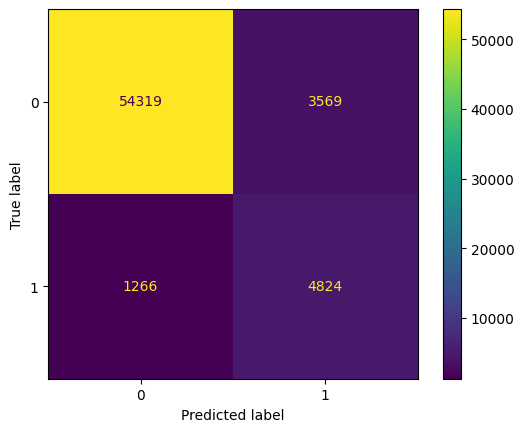

severe_toxic - Acc: 0.9935 - Recall: 0.2589 - Precision: 0.3958 - F1 score: 0.3130


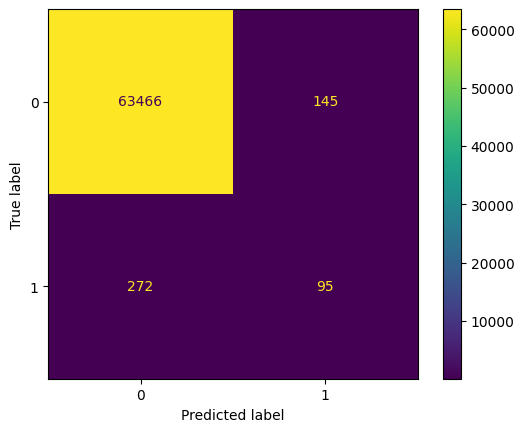

obscene - Acc: 0.9642 - Recall: 0.6286 - Precision: 0.7163 - F1 score: 0.6696


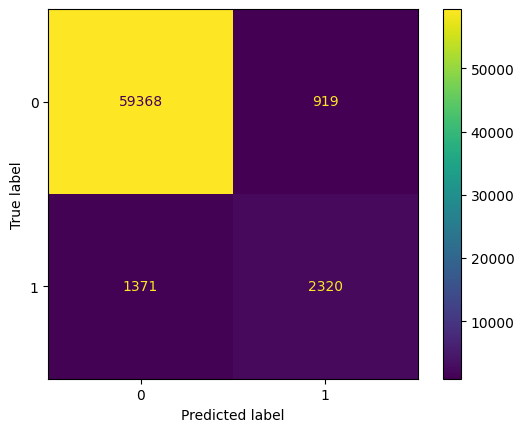

<ipython-input-28-e33fee1fdeaa>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_pos / (true_pos + false_pos)


threat - Acc: 0.9967 - Recall: 0.0000 - Precision: nan - F1 score: nan


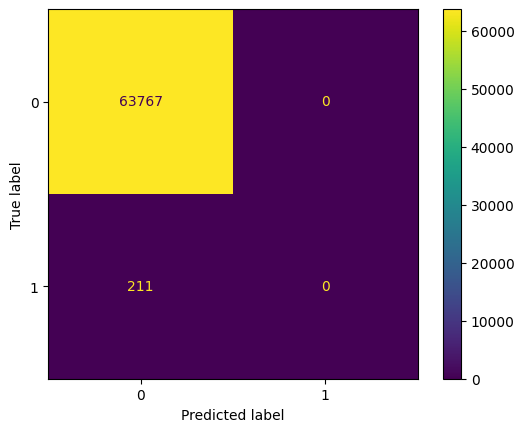

insult - Acc: 0.9566 - Recall: 0.5897 - Precision: 0.5963 - F1 score: 0.5930


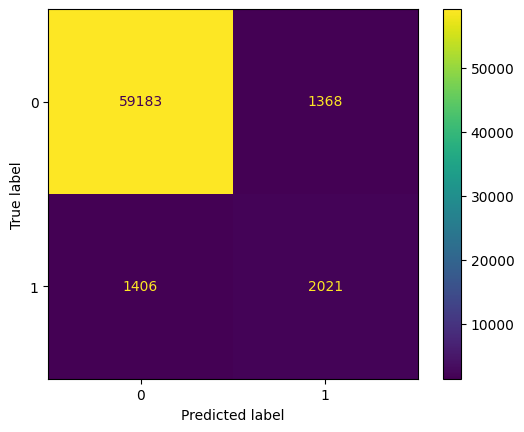

identity_hate - Acc: 0.9891 - Recall: 0.0309 - Precision: 0.7333 - F1 score: 0.0593


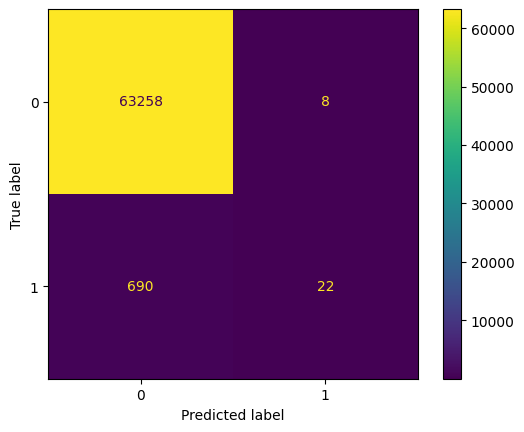

In [44]:
mr_preds = model_metrics(model_rnn)

In [45]:
model_comments(3, mr_preds)

Total Predictions: 63978
Total Toxic Comments with label `threat`: 211
Percentage of all-zero predictions: 13.744075829383887


In [46]:
model_comments(5, mr_preds)

Total Predictions: 63978
Total Toxic Comments with label `identity_hate`: 712
Percentage of all-zero predictions: 11.51685393258427


In [47]:
embedding_layer_rnn.trainable = True
model_rnn.compile(
  loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["binary_accuracy", auc_metric]
)

Epoch 1/20
1995/1995 [==============================] - 141s 69ms/step - loss: 0.0463 - binary_accuracy: 0.9823 - auc: 0.9671 - val_loss: 0.0456 - val_binary_accuracy: 0.9824 - val_auc: 0.9703
Epoch 2/20
1995/1995 [==============================] - 78s 39ms/step - loss: 0.0391 - binary_accuracy: 0.9845 - auc: 0.9799 - val_loss: 0.0460 - val_binary_accuracy: 0.9823 - val_auc: 0.9701
Epoch 3/20
1995/1995 [==============================] - 80s 40ms/step - loss: 0.0340 - binary_accuracy: 0.9862 - auc: 0.9853 - val_loss: 0.0482 - val_binary_accuracy: 0.9816 - val_auc: 0.9674


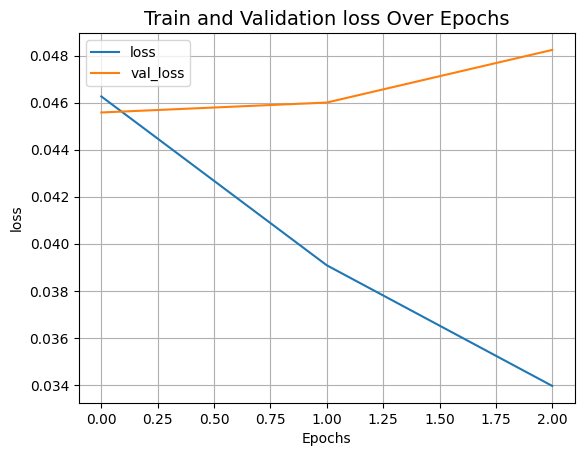

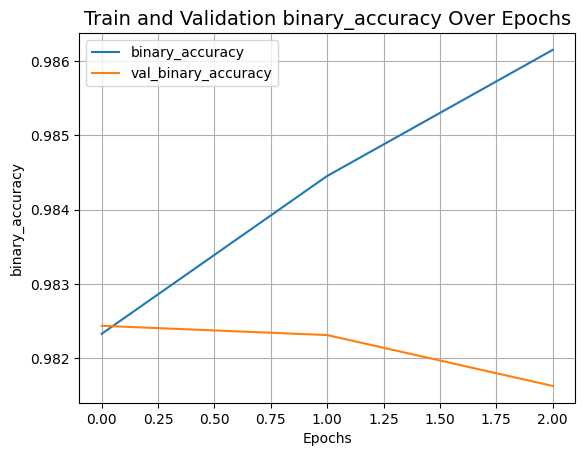

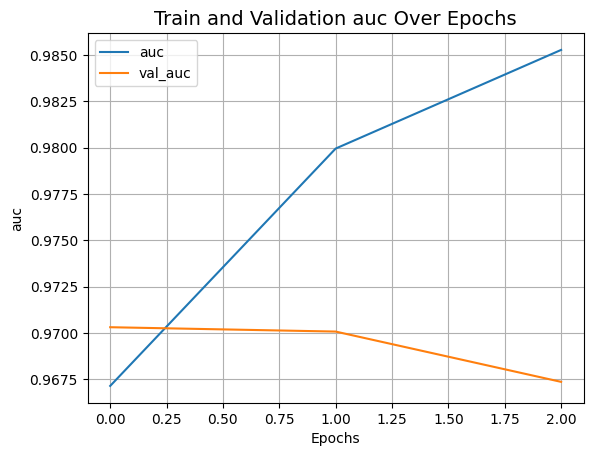

In [48]:
train_model(model_rnn, EarlyStopping(monitor="val_loss", min_delta = 0.005, patience=2, restore_best_weights=True))

In [49]:
model_rnn.evaluate(ds_test)

1000/1000 [==============================] - 11s 11ms/step - loss: 0.0759 - binary_accuracy: 0.9683 - auc: 0.9698


[0.07590867578983307, 0.9682944416999817, 0.9698171019554138]

1000/1000 [==============================] - 9s 9ms/step
ROC AUC Score per Label	 [0.96517733 0.98831291 0.97742291 0.96901995 0.96981748 0.97177211]
Micro ROC AUC Score	 0.9792091227929329
Macro ROC AUC Score	 0.97358711360003
Weighted ROC AUC Score	 0.9703571653207883
               precision    recall  f1-score   support

        toxic       0.54      0.87      0.66      6090
 severe_toxic       0.38      0.43      0.40       367
      obscene       0.62      0.79      0.69      3691
       threat       0.00      0.00      0.00       211
       insult       0.56      0.71      0.63      3427
identity_hate       0.60      0.13      0.21       712

    micro avg       0.56      0.75      0.64     14498
    macro avg       0.45      0.49      0.43     14498
 weighted avg       0.56      0.75      0.62     14498
  samples avg       0.07      0.07      0.07     14498

toxic - Acc: 0.9161 - Recall: 0.8668 - Precision: 0.5369 - F1 score: 0.6631


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


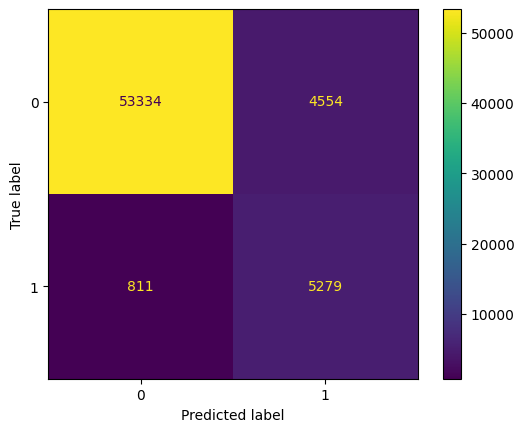

severe_toxic - Acc: 0.9927 - Recall: 0.4251 - Precision: 0.3814 - F1 score: 0.4021


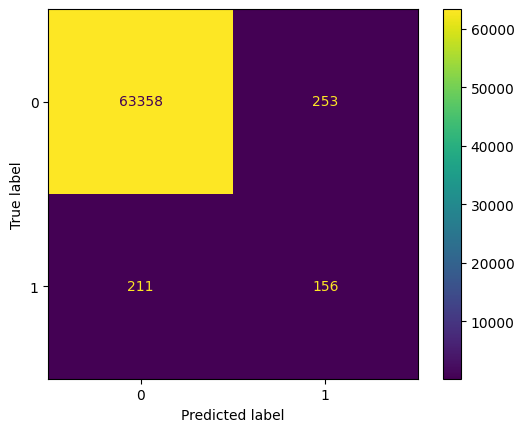

obscene - Acc: 0.9598 - Recall: 0.7889 - Precision: 0.6192 - F1 score: 0.6938


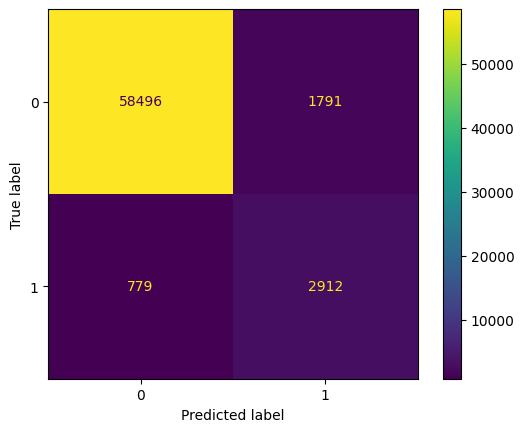

threat - Acc: 0.9967 - Recall: 0.0000 - Precision: nan - F1 score: nan


<ipython-input-28-e33fee1fdeaa>:10: RuntimeWarning: invalid value encountered in long_scalars
  precision = true_pos / (true_pos + false_pos)


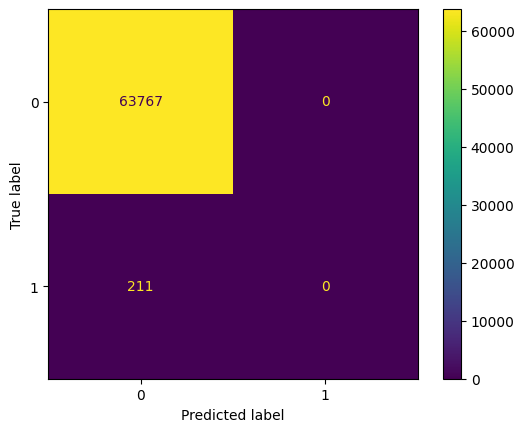

insult - Acc: 0.9550 - Recall: 0.7076 - Precision: 0.5636 - F1 score: 0.6274


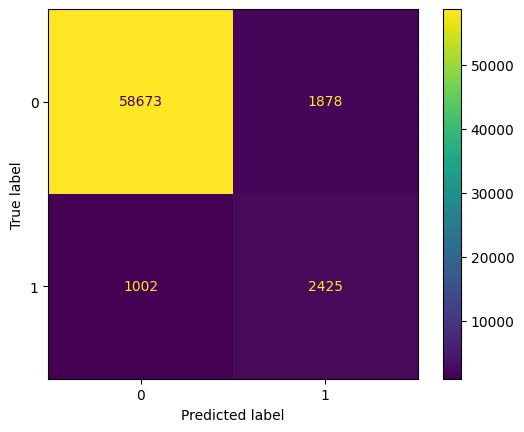

identity_hate - Acc: 0.9894 - Recall: 0.1264 - Precision: 0.6040 - F1 score: 0.2091


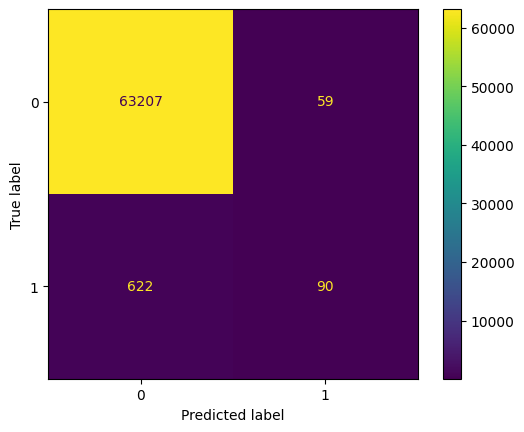

In [50]:
mrr_preds = model_metrics(model_rnn)

In [51]:
model_comments(3, mrr_preds)

Total Predictions: 63978
Total Toxic Comments with label `threat`: 211
Percentage of all-zero predictions: 9.004739336492891


In [52]:
model_comments(5, mrr_preds)

Total Predictions: 63978
Total Toxic Comments with label `identity_hate`: 712
Percentage of all-zero predictions: 7.584269662921348


### CNN

Epoch 1/20
1995/1995 [==============================] - 38s 18ms/step - loss: 0.0583 - binary_accuracy: 0.9791 - auc: 0.9544 - val_loss: 0.0492 - val_binary_accuracy: 0.9813 - val_auc: 0.9730
Epoch 2/20
1995/1995 [==============================] - 31s 16ms/step - loss: 0.0435 - binary_accuracy: 0.9830 - auc: 0.9772 - val_loss: 0.0498 - val_binary_accuracy: 0.9815 - val_auc: 0.9679
Epoch 3/20
1995/1995 [==============================] - 31s 16ms/step - loss: 0.0365 - binary_accuracy: 0.9854 - auc: 0.9866 - val_loss: 0.0551 - val_binary_accuracy: 0.9812 - val_auc: 0.9554


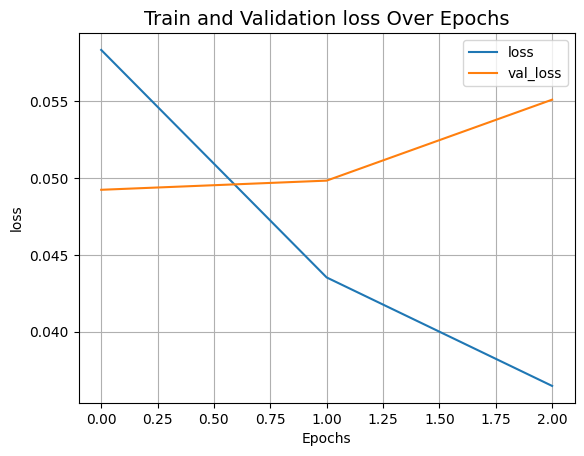

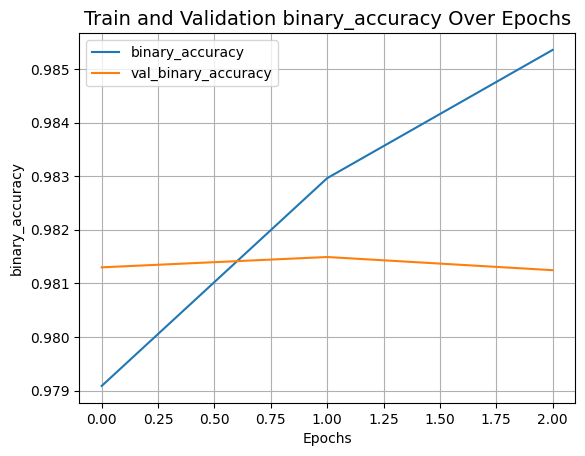

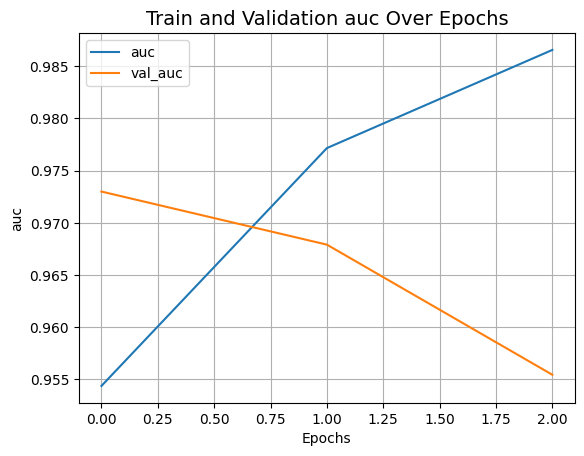

In [53]:
train_model(model_cnn, EarlyStopping(monitor="val_loss", min_delta = 0.01, patience=2, restore_best_weights=True))

In [54]:
model_cnn.evaluate(ds_test)

1000/1000 [==============================] - 7s 7ms/step - loss: 0.0676 - binary_accuracy: 0.9726 - auc: 0.9677


[0.06763572245836258, 0.9726260900497437, 0.967675507068634]

1000/1000 [==============================] - 6s 5ms/step
ROC AUC Score per Label	 [0.96077783 0.98399746 0.97356999 0.97961573 0.96790984 0.97893563]
Micro ROC AUC Score	 0.9776300497534861
Macro ROC AUC Score	 0.9741344134701482
Weighted ROC AUC Score	 0.9674740641031682
               precision    recall  f1-score   support

        toxic       0.59      0.79      0.68      6090
 severe_toxic       0.44      0.21      0.29       367
      obscene       0.71      0.63      0.67      3691
       threat       0.41      0.08      0.13       211
       insult       0.66      0.59      0.63      3427
identity_hate       0.78      0.21      0.32       712

    micro avg       0.63      0.65      0.64     14498
    macro avg       0.60      0.42      0.45     14498
 weighted avg       0.64      0.65      0.63     14498
  samples avg       0.07      0.06      0.06     14498

toxic - Acc: 0.9285 - Recall: 0.7931 - Precision: 0.5929 - F1 score: 0.6786


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


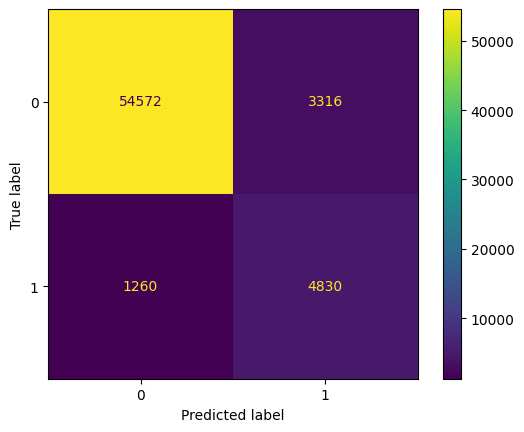

severe_toxic - Acc: 0.9939 - Recall: 0.2125 - Precision: 0.4382 - F1 score: 0.2862


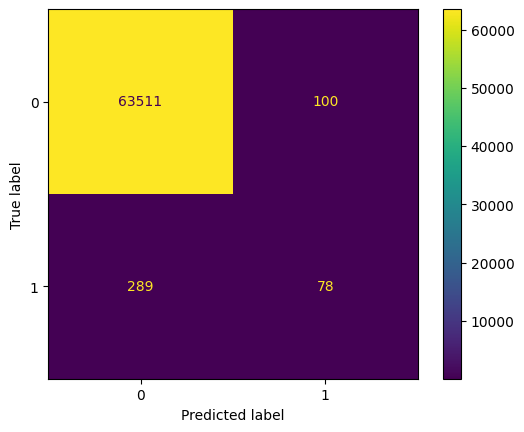

obscene - Acc: 0.9642 - Recall: 0.6342 - Precision: 0.7129 - F1 score: 0.6713


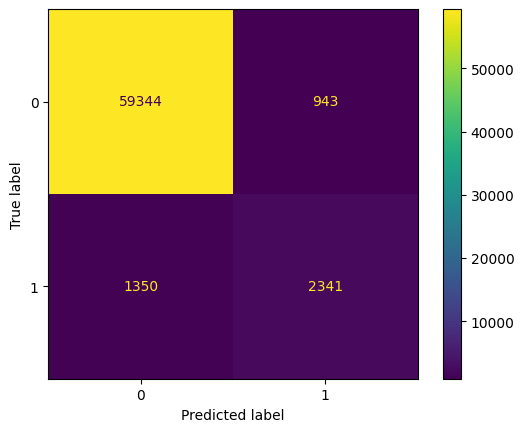

threat - Acc: 0.9966 - Recall: 0.0758 - Precision: 0.4103 - F1 score: 0.1280


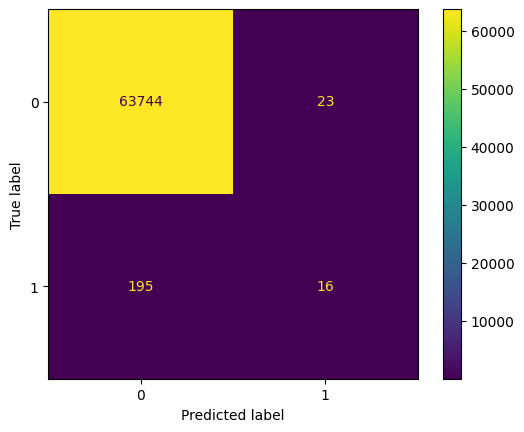

insult - Acc: 0.9621 - Recall: 0.5906 - Precision: 0.6645 - F1 score: 0.6254


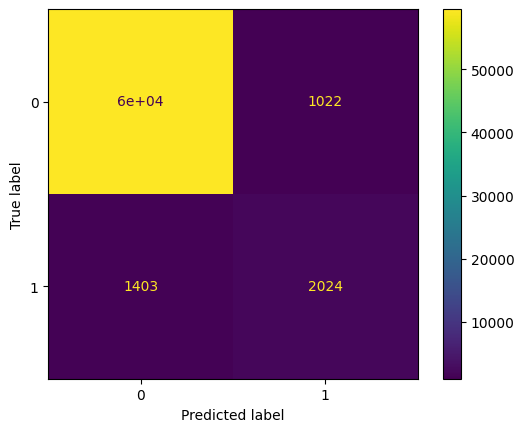

identity_hate - Acc: 0.9905 - Recall: 0.2051 - Precision: 0.7807 - F1 score: 0.3248


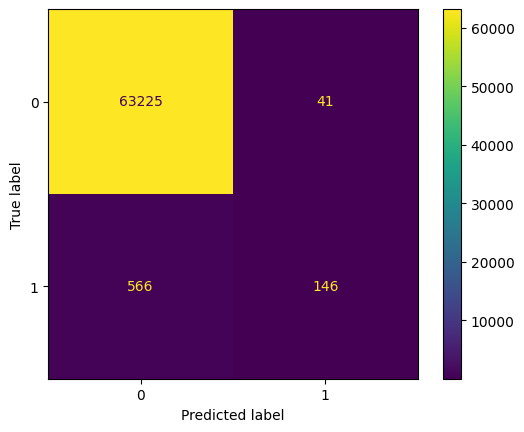

In [55]:
mc_preds = model_metrics(model_cnn)

In [56]:
model_comments(3, mc_preds)

Total Predictions: 63978
Total Toxic Comments with label `threat`: 211
Percentage of all-zero predictions: 16.587677725118482


In [57]:
model_comments(5, mc_preds)

Total Predictions: 63978
Total Toxic Comments with label `identity_hate`: 712
Percentage of all-zero predictions: 12.640449438202246


In [58]:
embedding_layer_cnn.trainable = True
model_cnn.compile(
  loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["binary_accuracy", auc_metric]
)

Epoch 1/20
1995/1995 [==============================] - 123s 61ms/step - loss: 0.0394 - binary_accuracy: 0.9844 - auc: 0.9780 - val_loss: 0.0450 - val_binary_accuracy: 0.9829 - val_auc: 0.9743
Epoch 2/20
1995/1995 [==============================] - 65s 32ms/step - loss: 0.0308 - binary_accuracy: 0.9874 - auc: 0.9901 - val_loss: 0.0486 - val_binary_accuracy: 0.9829 - val_auc: 0.9635
Epoch 3/20
1995/1995 [==============================] - 65s 33ms/step - loss: 0.0234 - binary_accuracy: 0.9906 - auc: 0.9944 - val_loss: 0.0547 - val_binary_accuracy: 0.9823 - val_auc: 0.9531


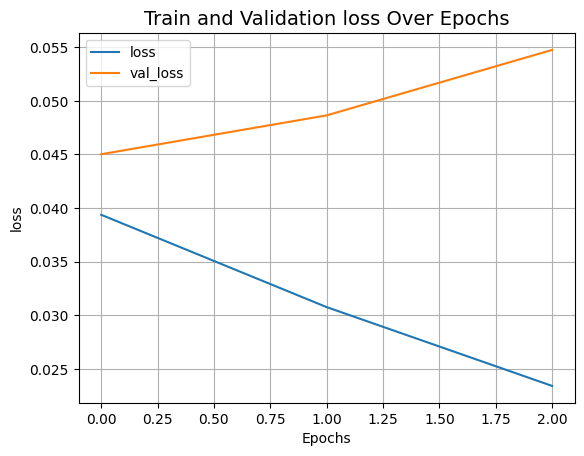

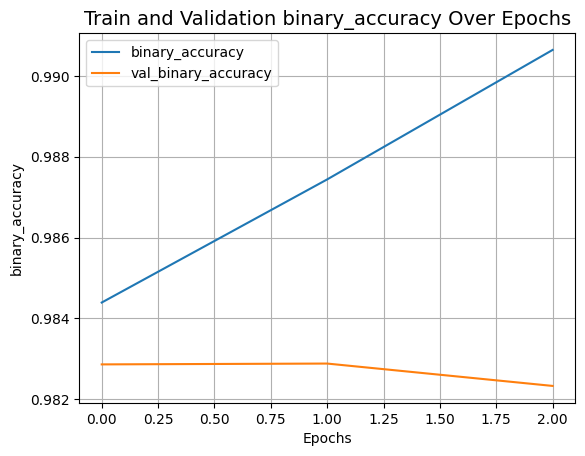

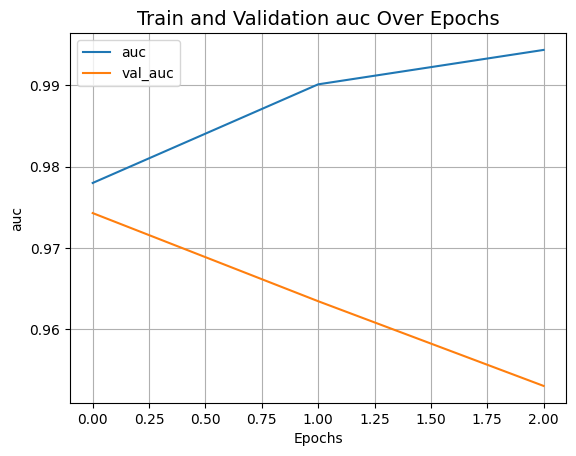

In [59]:
train_model(model_cnn, EarlyStopping(monitor="val_loss", min_delta = 0.005, patience=2, restore_best_weights=True))

In [60]:
model_cnn.evaluate(ds_test)

1000/1000 [==============================] - 7s 7ms/step - loss: 0.0736 - binary_accuracy: 0.9690 - auc: 0.9725


[0.07358168065547943, 0.9690359830856323, 0.9724600315093994]

1000/1000 [==============================] - 6s 6ms/step
ROC AUC Score per Label	 [0.96568001 0.98645248 0.97612483 0.98351827 0.97252641 0.98359655]
Micro ROC AUC Score	 0.9809867424115599
Macro ROC AUC Score	 0.9779830915366478
Weighted ROC AUC Score	 0.9716227883635156
               precision    recall  f1-score   support

        toxic       0.54      0.86      0.67      6090
 severe_toxic       0.38      0.43      0.41       367
      obscene       0.61      0.78      0.68      3691
       threat       0.35      0.24      0.28       211
       insult       0.59      0.73      0.65      3427
identity_hate       0.67      0.45      0.54       712

    micro avg       0.57      0.77      0.65     14498
    macro avg       0.52      0.58      0.54     14498
 weighted avg       0.57      0.77      0.65     14498
  samples avg       0.07      0.07      0.07     14498

toxic - Acc: 0.9176 - Recall: 0.8637 - Precision: 0.5423 - F1 score: 0.6662


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


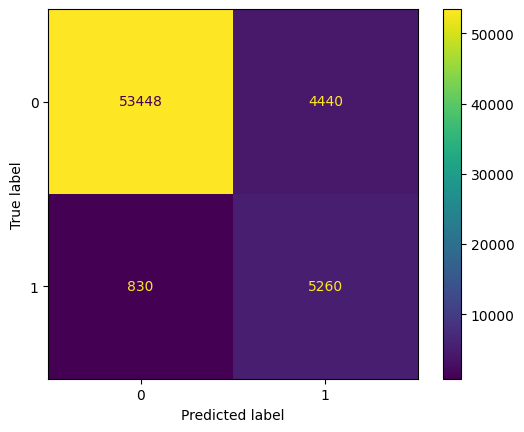

severe_toxic - Acc: 0.9927 - Recall: 0.4332 - Precision: 0.3804 - F1 score: 0.4051


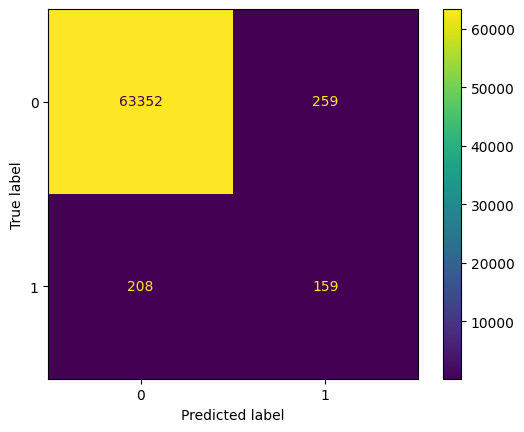

obscene - Acc: 0.9581 - Recall: 0.7784 - Precision: 0.6070 - F1 score: 0.6821


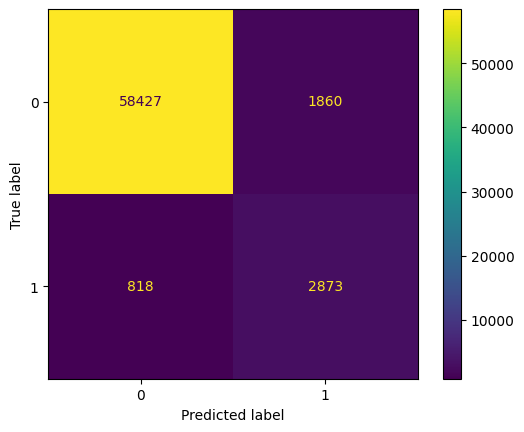

threat - Acc: 0.9960 - Recall: 0.2370 - Precision: 0.3472 - F1 score: 0.2817


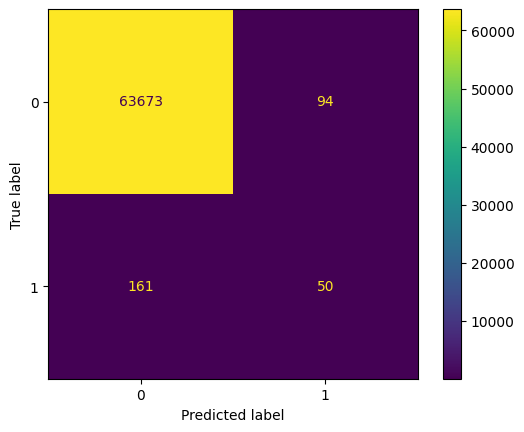

insult - Acc: 0.9583 - Recall: 0.7272 - Precision: 0.5901 - F1 score: 0.6515


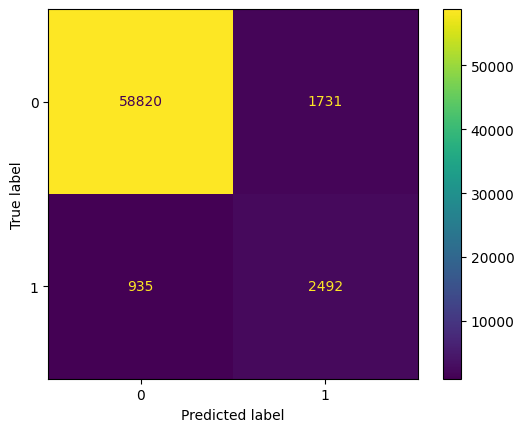

identity_hate - Acc: 0.9914 - Recall: 0.4480 - Precision: 0.6702 - F1 score: 0.5370


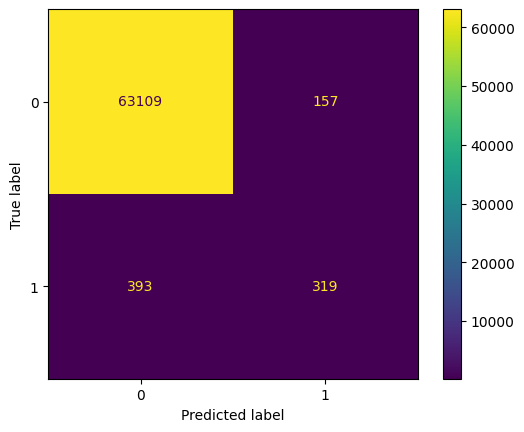

In [61]:
mcc_preds = model_metrics(model_cnn)

In [62]:
model_comments(3, mcc_preds)

Total Predictions: 63978
Total Toxic Comments with label `threat`: 211
Percentage of all-zero predictions: 9.004739336492891


In [63]:
model_comments(5, mcc_preds)

Total Predictions: 63978
Total Toxic Comments with label `identity_hate`: 712
Percentage of all-zero predictions: 8.146067415730338
